# 5. Optimal Skills

### Importar módulos y librerías

In [ ]:
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset

### Cargar datos

In [2]:
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

### Limpieza de datos

In [3]:
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

Creamos un nuevo DataFrame para guardar los puestos de trabajo de Data Analyst que sean de Argentina

In [4]:
df_DA_ARG = df[(df['job_title_short'] == 'Data Analyst') & (df['job_country'] == 'Argentina')].copy()

df_DA_ARG = df_DA_ARG.dropna(subset=['salary_year_avg'])

df_DA_ARG_exploded = df_DA_ARG.explode('job_skills')

df_DA_ARG_exploded[['salary_year_avg', 'job_skills']].head(5)

,salary_year_avg,job_skills
93501,111202.0,sql
93501,111202.0,python
93501,111202.0,flow
345103,45000.0,sql
345103,45000.0,python


### Calcular el porcentaje de ofertas de trabajo que tienen skills

Agrupamos los datos por skills y calculamos la cantidad y la mediana del salario para cada skill.
Ordenamos los resultados en orden descendente.

In [5]:
df_DA_skills = df_DA_ARG_exploded.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='count', ascending=False)

Renombramos las columnas.

In [6]:
df_DA_skills = df_DA_skills.rename(columns={'count': 'skill_count', 'median': 'median_salary'})

Obtenemos la cantidad de puestos de Data Analyst que tengan información disponible sobre el salario

In [7]:
DA_job_count = len(df_DA_ARG)  

Calculamos el porcentaje que cada cantidad de skills representa del total de puestos de Data Analyst. 
Se filtran las skills que no tienen puestos de trabajo asociados a ellas.

In [8]:
df_DA_skills['skill_percent'] = df_DA_skills['skill_count'] / DA_job_count * 100

df_DA_skills = df_DA_skills[df_DA_skills['skill_count'] > 0]

df_DA_skills

,skill_count,median_salary,skill_percent
job_skills,,,
sql,3,111175.0,75.0
python,3,111175.0,75.0
excel,1,45000.0,25.0
flow,1,111202.0,25.0
power bi,1,45000.0,25.0
javascript,1,45000.0,25.0
sql server,1,45000.0,25.0
tableau,1,45000.0,25.0


### Scatter plot: Mediana del salario vs Porcentaje de demanda de skills

Para graficar posteriormente, vamos a poner la condición de que el porcentaje de skills debe ser mayor al 5%

In [20]:
skill_limit = 20

df_DA_skills_high_demand = df_DA_skills[df_DA_skills['skill_percent'] > skill_limit]

6 [-0.53088212  0.8364587 ]
7 [-0.02872243 -0.60272792]


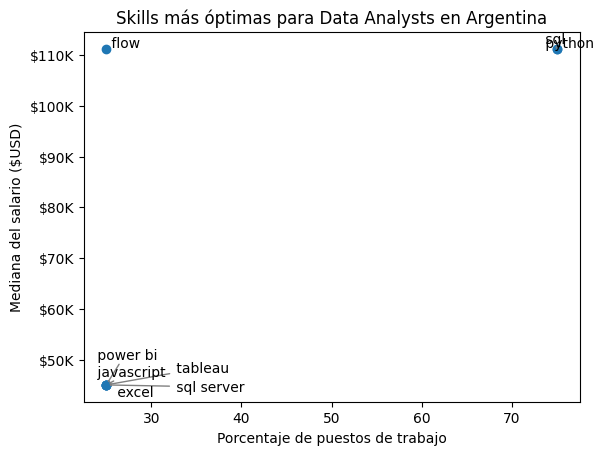

In [21]:
from adjustText import adjust_text

plt.scatter(df_DA_skills_high_demand['skill_percent'], df_DA_skills_high_demand['median_salary'])
plt.xlabel('Porcentaje de puestos de trabajo')
plt.ylabel('Mediana del salario ($USD)')
plt.title('Skills más óptimas para Data Analysts en Argentina')

# Get current axes, set limits, and format axes
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))  # Example formatting y-axis

# Add labels to points and collect them in a list
texts = []
for i, txt in enumerate(df_DA_skills_high_demand.index):
    texts.append(plt.text(df_DA_skills_high_demand['skill_percent'].iloc[i], df_DA_skills_high_demand['median_salary'].iloc[i], " " + txt))

# Ajusta el texto para evitar superposiciones
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

plt.show()

### Colorear por skills

In [28]:
df_technology = df['job_type_skills'].copy()

# Eliminamos duplicados
df_technology = df_technology.drop_duplicates()

# Elimninamos filas con valores nulos
df_technology = df_technology.dropna()

# Combinamos los diccionarios de skills en una sola lista
technology_dict = {}
for row in df_technology:
    row_dict = ast.literal_eval(row)  # Conversión string a diccionario
    for key, value in row_dict.items():
        if key in technology_dict:  # if key already exists in technology_dict, add value to existing value
            technology_dict[key] += value
        else:                       # if key does not exist in technology_dict, add key and value
            technology_dict[key] = value

# Remove duplicates by converting values to set then back to list
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

technology_dict

KeyboardInterrupt: 

In [25]:
# Convertimos el diccionario a un DataFrame
df_technology = pd.DataFrame(list(technology_dict.items()), columns=['technology', 'skills'])

df_technology = df_technology.explode('skills')

df_technology

,technology,skills
0,analyst_tools,datarobot
0,analyst_tools,sap
0,analyst_tools,msaccess
0,analyst_tools,looker
0,analyst_tools,splunk
...,...,...
9,sync,microsoft teams
9,sync,wire
9,sync,zoom
9,sync,unify


In [26]:
# Mergea los DataFrames, df_DA_skills and df_technology, basado en la columna job_skills y skills, 
# creando el nuevo DataFrame df_DA_skills_tech.

df_DA_skills_tech = df_DA_skills.merge(df_technology, left_on='job_skills', right_on='skills')

df_DA_skills_tech

,skill_count,median_salary,skill_percent,technology,skills
0,3,111175.0,75.0,programming,sql
1,3,111175.0,75.0,programming,python
2,1,45000.0,25.0,analyst_tools,excel
3,1,111202.0,25.0,other,flow
4,1,45000.0,25.0,analyst_tools,power bi
5,1,45000.0,25.0,programming,javascript
6,1,45000.0,25.0,databases,sql server
7,1,45000.0,25.0,analyst_tools,tableau


In [27]:
# Filtro: si el porcentaje supera el skill limit (definido anteriormente como 20)
df_DA_skills_tech_high_demand = df_DA_skills_tech[df_DA_skills_tech['skill_percent'] > skill_limit]

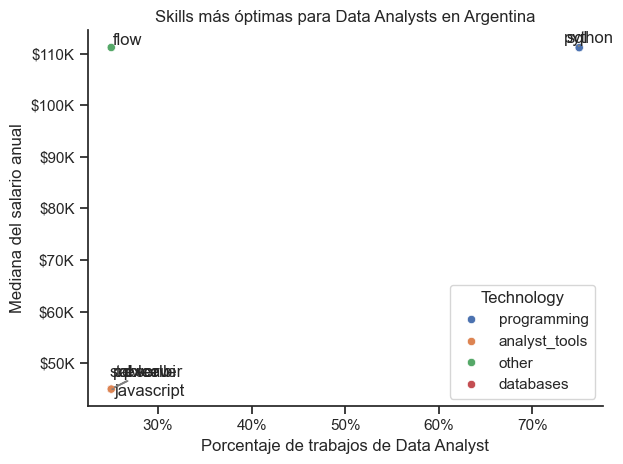

In [30]:
sns.scatterplot(
    data=df_DA_skills_tech_high_demand,
    x='skill_percent',
    y='median_salary',
    hue='technology'
)

sns.despine()
sns.set_theme(style='ticks')

# Prepare texts for adjustText
texts = []
for i, txt in enumerate(df_DA_skills_high_demand.index):
    texts.append(plt.text(df_DA_skills_high_demand['skill_percent'].iloc[i], df_DA_skills_high_demand['median_salary'].iloc[i], txt))

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

# Set axis labels, title, and legend
plt.xlabel('Porcentaje de trabajos de Data Analyst')
plt.ylabel('Mediana del salario anual')
plt.title('Skills más óptimas para Data Analysts en Argentina')
plt.legend(title='Technology')

from matplotlib.ticker import PercentFormatter
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

# Adjust layout and display plot 
plt.tight_layout()
plt.show()